# Phytoplankton

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import os.path as op
import sys

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_base_map, plot_map_subplots, plot_bar_probs
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import download_ERDDAP_data


Define area of interest

In [3]:
#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

EEZ shapefile

In [4]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

## Download Data

DATASET: https://oceanwatch.pifsc.noaa.gov/erddap/info/md50_exp/index.html


In [5]:
update_data = False
path_data = "../../../data"

In [6]:
base_url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/md50_exp.csv'
dataset_id = 'MD50'

if update_data:
    date_ini = '1998-01-01T00:00:00Z'
    date_end = '2023-12-01T00:00:00Z'
    data = download_ERDDAP_data(base_url, dataset_id, date_ini, date_end, lon_range, lat_range)
    data_xr = data.set_index(['latitude', 'longitude', 'time']).to_xarray()
    data_xr['time'] = pd.to_datetime(data_xr.time)
    data_xr = data_xr.coarsen(longitude=2, latitude=2, boundary = 'pad').mean()
    data_xr.to_netcdf(op.join(path_data, f'griddap_{dataset_id}.nc'))
else:
    data_xr = xr.open_dataset(op.join(path_data, f'griddap_{dataset_id}.nc'))

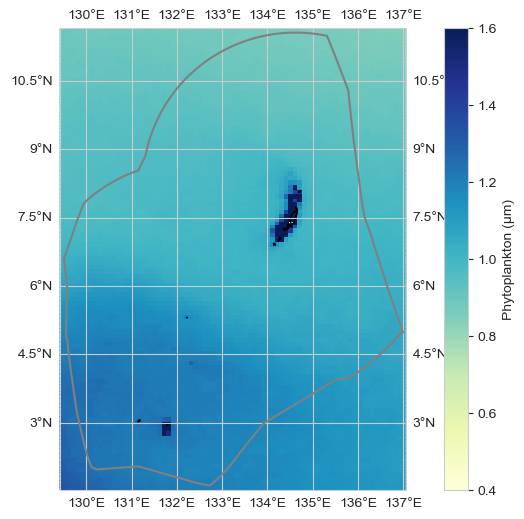

In [7]:
ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
im = ax.pcolor(data_xr.longitude, data_xr.latitude, data_xr.mean(dim='time')[dataset_id], transform=ccrs.PlateCarree(), 
                cmap = 'YlGnBu', vmin = 0.4, vmax = 1.6)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, label='Phytoplankton (µm)')


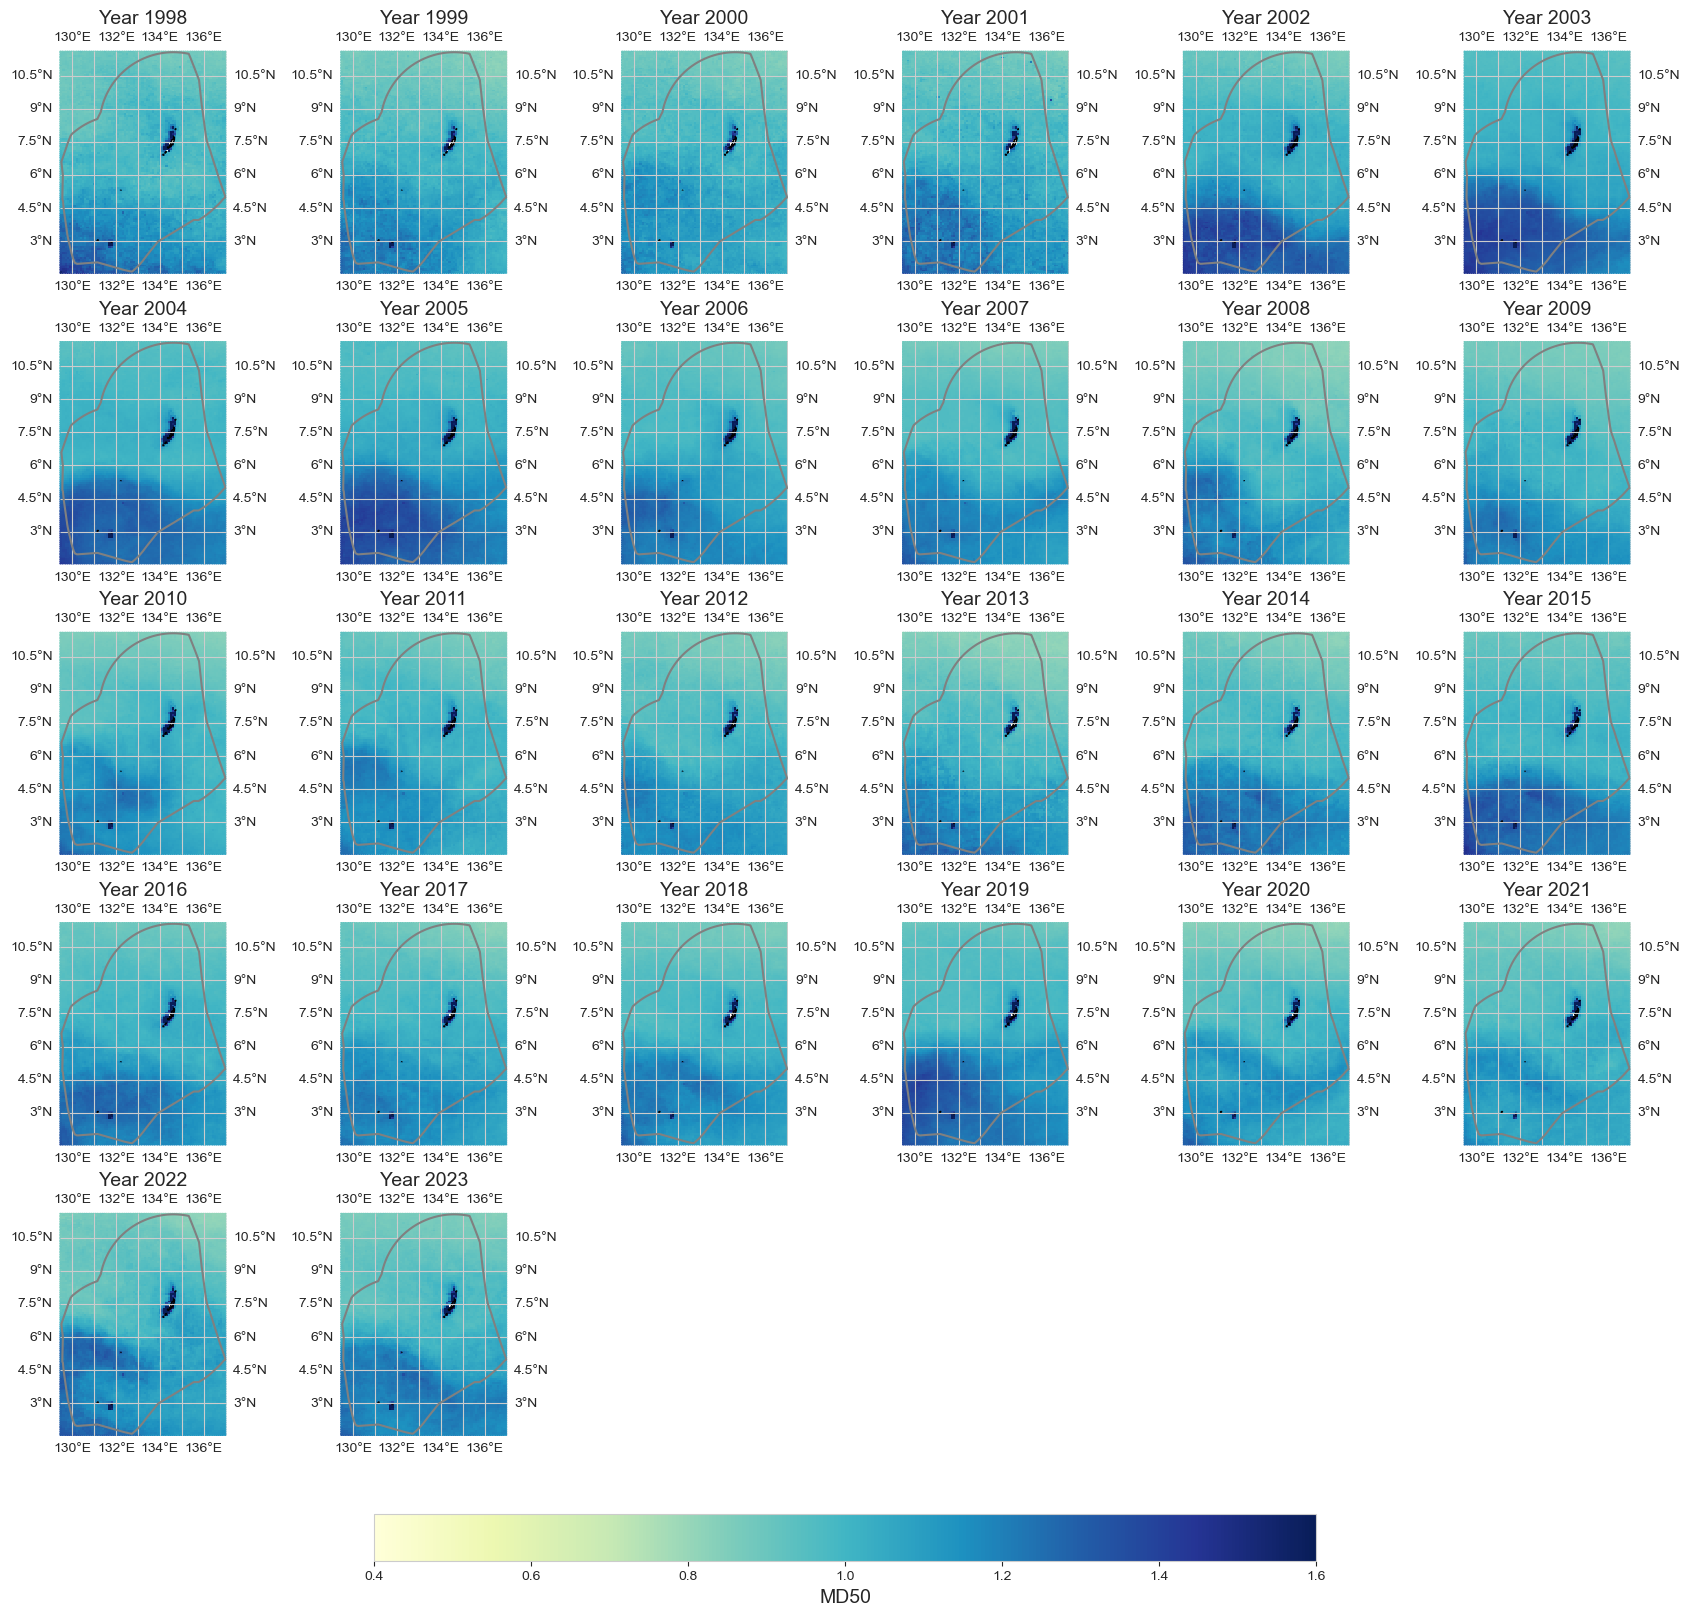

In [8]:
data_y = data_xr.resample(time='1YE').mean()
plot_map_subplots(data_y, 'MD50', shp_eez = shp_eez, cmap = 'YlGnBu', vmin = 0.4, vmax = 1.6, cbar = 1)

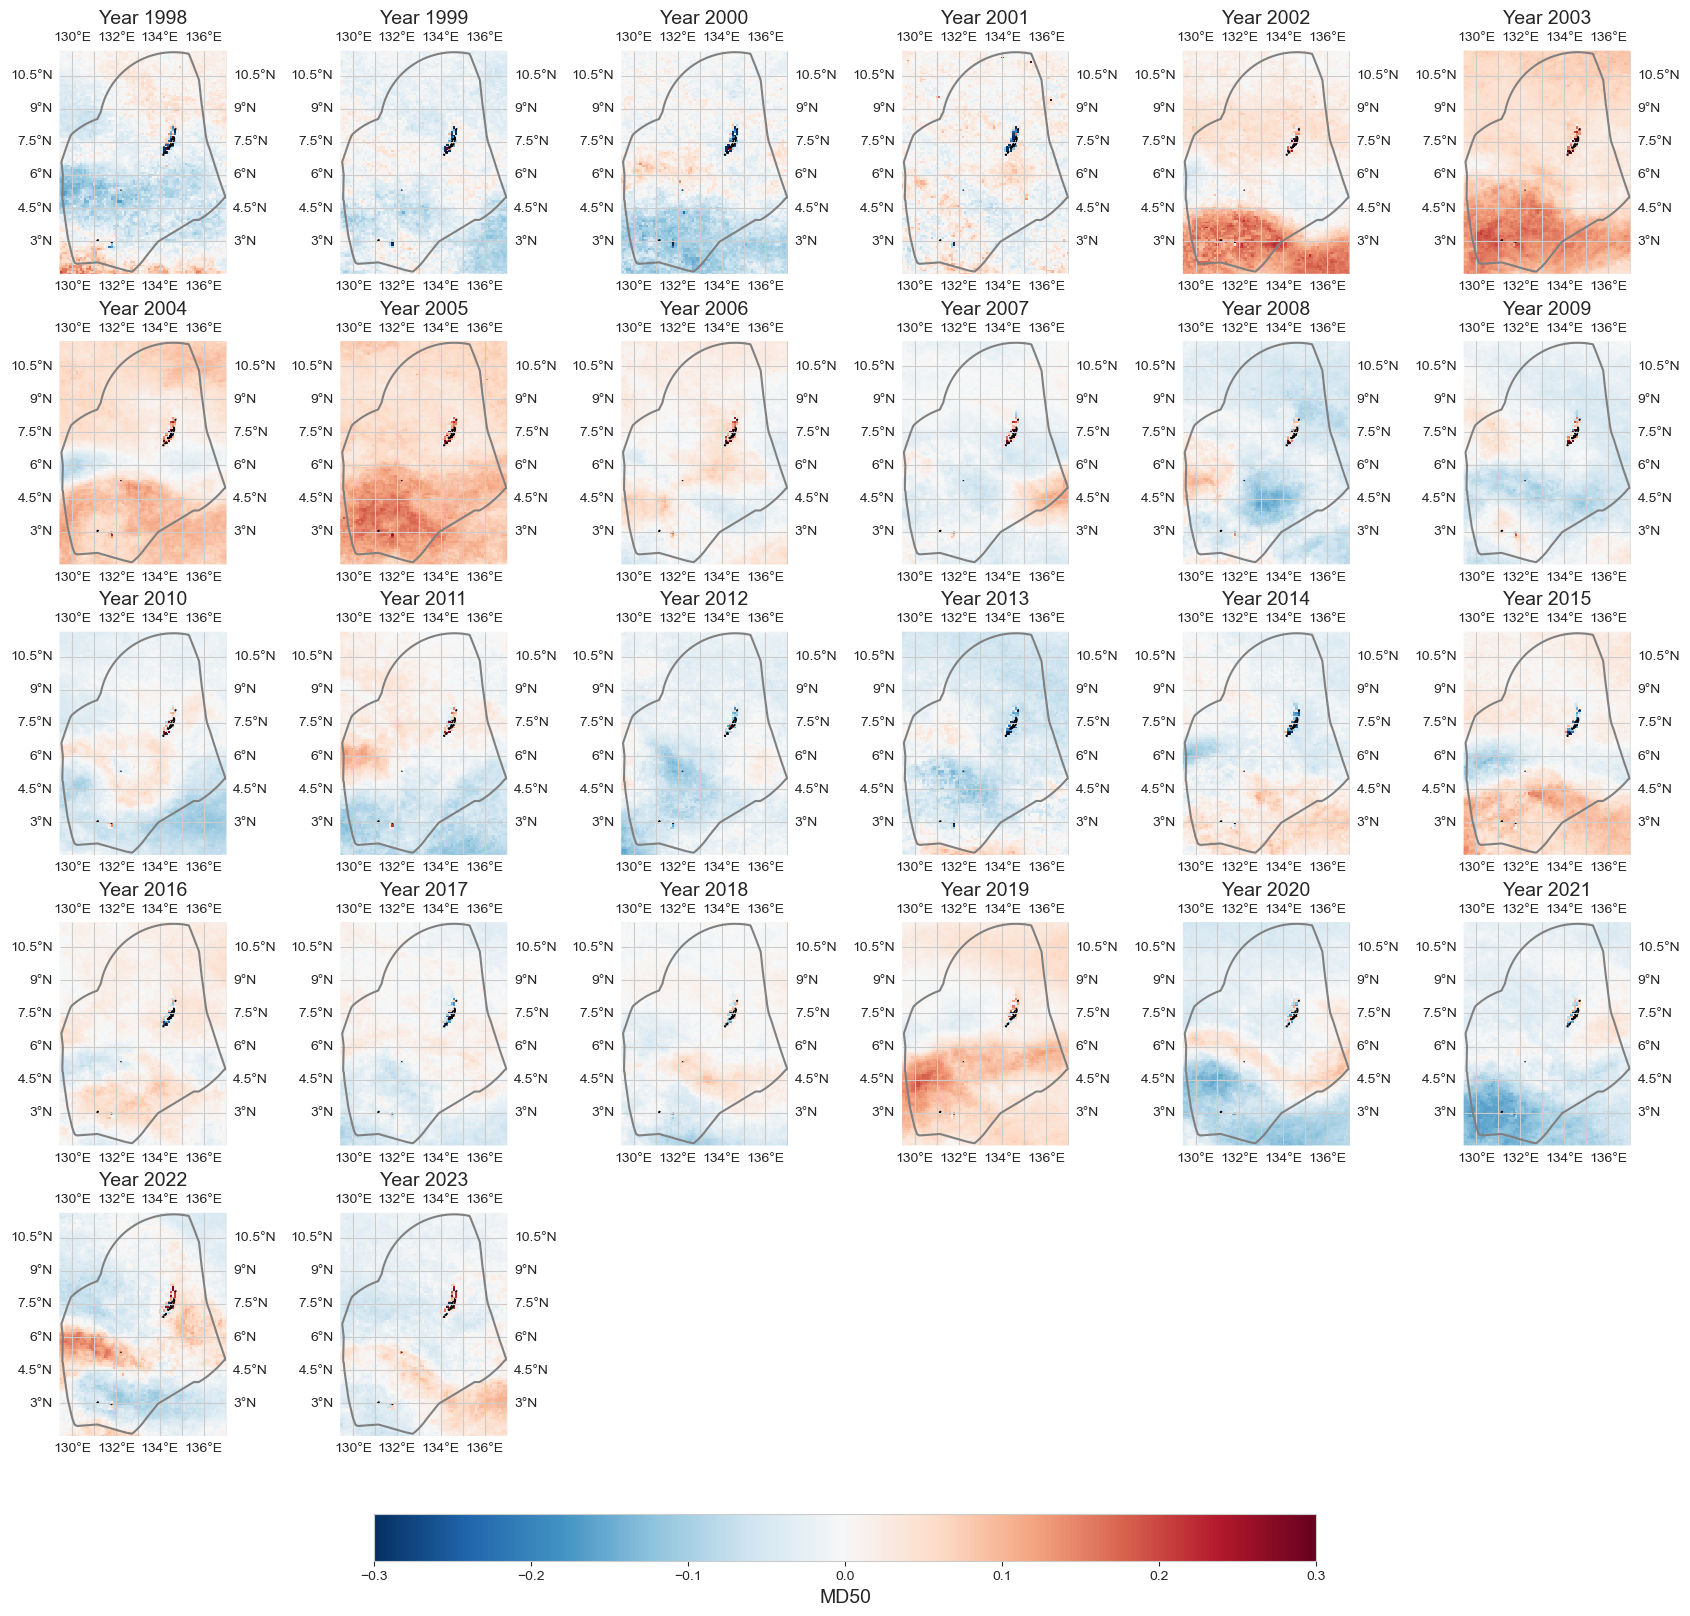

In [9]:
data_an = data_y - data_xr.mean(dim='time')
plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.3, vmax=.3, cbar = 1)

## Mean Area

In [10]:
dict_plot = [{'data' : data_xr.mean(dim = ['longitude', 'latitude']).to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : 'Median Phytoplankton Size - MEAN AREA'},]

In [11]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12));

## Given point

In [12]:
loc = [7.35, 134.48]
dict_plot = [{'data' : data_xr.sel(longitude=loc[1], latitude=loc[0], method='nearest').to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : f'Median Phytoplankton Size at [{loc[0]}, {loc[1]}]'},]

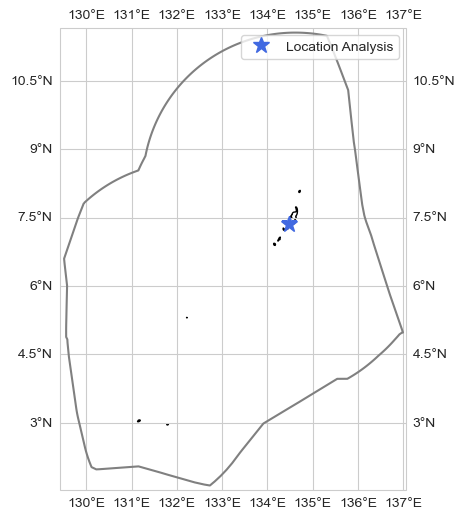

In [13]:
ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
ax.plot(loc[1], loc[0], '*', markersize = 12, color = 'royalblue', transform=ccrs.PlateCarree(), label = 'Location Analysis')
ax.legend()

In [14]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12));